# effiency of $CC1p$ events

In [1]:
from Xsec_setup import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/Xsec/Figures/efficiencies/'

In [3]:
versions['overlay date'] = '2018_08_16'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
selected_path = '/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/'
prefix = selected_path + versions['Overlay'] + '_' + versions['overlay date'] + '_'
selected_overlay=dict()

cuts_order  = ['no cut','Chi2Proton','Nflashes','MatchedFlash','length'
               ,'non-collinearity','vertex activity'
               ,'delta phi','Pt & delta phi']
cutlabels = ['preselection','$dE/dx$ profile',r'$N_{flashes}>0$','optical filter','track lengths'
             ,'non-collinearity','vertex activity'
             ,'coplanarity','$p_t<0.35$ GeV/c']

if os.path.isfile(prefix+'selected_cosmic.csv'): 
    print 'checked',prefix+'selected_cosmic.csv','and found the file...'
    for pair_type in pair_types:
        selected_overlay[pair_type]=pd.read_csv(prefix+'selected_'+pair_type+'.csv')

else:
    print 'checked',prefix+'selected_cosmic.csv','and there was no file there...'
    OverlaySamples = load_samples(date=versions['overlay date'],filename=versions['Overlay']+'_'+versions['overlay date']+'_vertices')
    reducedOverlay,pureffOverlay,pureffNumbers = apply_cuts_to_overlay(OverlaySamples=OverlaySamples, cuts_order=cuts_order)
    print 'applied cuts to overlay'
    for pair_type in pair_types:
        selected_overlay[pair_type] = reducedOverlay['Pt & delta phi'][pair_type]
        outcsvname = prefix+'selected_'+pair_type+'.csv'
        selected_overlay[pair_type].to_csv(outcsvname)
        print 'saved selected',pair_type,'to',outcsvname
    
    # overlay scaling
    summary = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/summary/'+versions['overlay date']+'/'+versions['Overlay']+'_'+versions['overlay date']+'_summary.csv')
    Nevents['OnBeam POT'] = 4.908e+19
    Nevents['overlay']      = np.sum(summary.Nevents)
    Nevents['overlay POT']  = np.sum(summary.POT)
    Nevents['f(POT)']       = Nevents['OnBeam POT']/Nevents['overlay POT']
    print "Nevents['f(POT)']:",Nevents['f(POT)']

selected_overlay_concat = pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])    
print len(selected_overlay_concat),'events in the overlay'

checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_cosmic.csv and found the file...
13596 events in the overlay


In [4]:
genie = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/genie/'
                    +versions['overlay date']+'/'
                    +versions['Overlay']+'_'+versions['overlay date']+'_genie.csv')
print len(genie),'events in genie'

930168 events in genie


In [5]:
genie_CC1p = genie[(genie.IsCC_1p_200MeVc==True) #& (genie.IsInActiveVolume==True) 
                       & ((genie.truth_x>3) & (genie.truth_x<256))
                       & ((genie.truth_y>-115) & (genie.truth_y<115))
                       & ((genie.truth_z>5) & (genie.truth_y<1037))
                      ]
selected_CC1p = selected_overlay['CC 1p']
print len(selected_CC1p),'selected CC1p events overlay'
print len(genie_CC1p),'CC1p events in genie'

10899 selected CC1p events overlay
128622 CC1p events in genie


In [13]:
def get_eff(Ngen=1,Nsel=1,debug=0):
    '''
    return: eff, eff_err    
    '''
    eff = float(Nsel)/Ngen if Ngen>0 else 0
    eff_err = eff*np.sqrt((1./Nsel if Nsel>0 else 0) + (1./Ngen if Ngen>0 else 0))
    if debug: print 'eff = %.4f +/ %.4f'%(eff,eff_err)
    return eff,eff_err

def get_eff_samples(generated=None,selected=None,debug=0):
    '''
    return: eff, eff_err    
    '''
    Ngen = float(len(generated))
    Nsel = float(len(selected))
    return get_eff(Ngen=Ngen,Nsel=Nsel,debug=debug)

## absolute efficiency

In [7]:
absolute_eff,absolute_eff_err = get_eff_samples(generated=genie_CC1p,selected=selected_CC1p)
print 'absolute efficiency: %.4f +/- %.4f'%(absolute_eff,absolute_eff_err)
np.savetxt(Paths['efficiency maps'] + "absolute_eff.csv", [absolute_eff,absolute_eff_err], delimiter=",")
print 'saved absolute efficiency and efficiency err into',Paths['efficiency maps'] + "absolute_eff.csv"

absolute efficiency: 0.0847 +/- 0.0008
saved absolute efficiency and efficiency err into /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/efficeincy_maps/absolute_eff.csv


## smear the generated observables

In [8]:
filename = Paths['migration maps'] + "%s_vs_%s_%d_bins.csv"%('truth_Pmu','reco_Pmu_mcs',len(Bins['Pmu'])-1)
migration_map_Pmu = np.loadtxt(filename,delimiter=',')
print 'migration_map_Pmu \n',migration_map_Pmu
filename = Paths['migration maps']  + "%s_vs_%s_%d_bins.csv"%('truth_Pmu_theta','reco_Pmu_mcs_theta',len(Bins['theta(mu)'])-1)
migration_map_Pmu_theta = np.loadtxt(filename,delimiter=',')
print 'migration_map_Pmu_theta \n',migration_map_Pmu_theta
filename = Paths['migration maps']  + "%s_vs_%s_%d_bins.csv"%('truth_Pmu_cos_theta','reco_Pmu_cos_theta',len(Bins['cos(theta(mu))'])-1)
migration_map_Pmu_cos_theta = np.loadtxt(filename,delimiter=',')
print 'migration_map_Pmu_cos_theta \n',migration_map_Pmu_cos_theta

filename = Paths['migration maps']  + "%s_vs_%s_%d_bins.csv"%('truth_Pp','reco_Pp',len(Bins['Pp'])-1)
migration_map_Pp = np.loadtxt(filename,delimiter=',')
print 'migration_map_Pp \n',migration_map_Pp
filename = Paths['migration maps']  + "%s_vs_%s_%d_bins.csv"%('truth_Pp_theta','reco_Pp_theta',len(Bins['theta(p)'])-1)
migration_map_Pp_theta = np.loadtxt(filename,delimiter=',')
print 'migration_map_Pp_theta \n',migration_map_Pp_theta
filename = Paths['migration maps']  + "%s_vs_%s_%d_bins.csv"%('truth_Pp_cos_theta','reco_Pp_cos_theta',len(Bins['cos(theta(p))'])-1)
migration_map_Pp_cos_theta = np.loadtxt(filename,delimiter=',')
print 'migration_map_Pp_cos_theta \n',migration_map_Pp_cos_theta


# fig,ax = plt.subplots(figsize=(9.708,6))
# sns.set(font_scale=2);
# sns.heatmap(migration_map,annot=True,fmt=".2f",cbar=False,cmap='jet')
# set_axes(ax,'True bin $j$','Reconstructed bin $i$')
# ax.invert_yaxis()
# plt.tight_layout()

migration_map_Pmu 
[[ 0.75713882  0.13926206  0.05568976  0.03557467  0.03195305  0.0351951 ]
 [ 0.20073509  0.68391675  0.20928163  0.08522283  0.07629605  0.07039021]
 [ 0.02403167  0.13254494  0.54075016  0.23475371  0.13955005  0.11323642]
 [ 0.01201583  0.02800378  0.14202161  0.47126661  0.26084121  0.1820964 ]
 [ 0.00339271  0.01182592  0.03636364  0.13213448  0.37398109  0.25554705]
 [ 0.00268589  0.00444655  0.0158932   0.04104769  0.11737855  0.34353481]]
migration_map_Pmu_theta 
[[  8.64960282e-01   4.22558369e-02   2.99865577e-03   6.26405397e-03
    5.97868469e-03   2.73822563e-03]
 [  1.28420124e-01   8.99292996e-01   6.50398097e-02   9.47638934e-03
    2.33948531e-03   5.47645126e-04]
 [  3.30979700e-03   5.13811246e-02   8.75710888e-01   7.40443302e-02
    2.07954250e-03   1.09529025e-03]
 [  1.32391880e-03   4.02828017e-03   4.79784924e-02   8.49341471e-01
    6.26462178e-02   1.64293538e-03]
 [  1.32391880e-03   1.64419599e-03   4.03267501e-03   5.18792162e-02
    8.6

In [9]:
def find_bin( x , bins ):    
    for i in range(len(bins)-1):
        if bins[i]<x and x<bins[i+1]:
            return i
    return 0

In [13]:
debug=0
smeared_Pmu_array,smeared_Pmu_theta_array,smeared_Pp_array,smeared_Pp_theta_array = [],[],[],[]
smeared_Pmu_cos_theta_array,smeared_Pp_cos_theta_array=[],[]
for i,row in selected_CC1p.iterrows():
    
    # smearing p(muon)
    true_bin_j = find_bin(row['truth_Pmu'], Bins['Pmu'])
    smeared_Pmu_array.append(choice(a=0.5*(Bins['Pmu'][1:]+Bins['Pmu'][:-1]) , p=migration_map_Pmu[:,true_bin_j]))

    # smearing theta(muon)
    true_bin_j = find_bin(180./np.pi*row['truth_Pmu_theta'], Bins['theta(mu)'])
    smeared_Pmu_theta_array.append(np.pi/180.*choice(a=0.5*(Bins['theta(mu)'][1:]+Bins['theta(mu)'][:-1]) , p=migration_map_Pmu_theta[:,true_bin_j]))

    # smearing cos(theta(muon))
    true_bin_j = find_bin(row['truth_Pmu_cos_theta'], Bins['cos(theta(mu))'])
    smeared_Pmu_cos_theta_array.append(choice(a=0.5*(Bins['cos(theta(mu))'][1:]+Bins['cos(theta(mu))'][:-1]) , p=migration_map_Pmu_cos_theta[:,true_bin_j]))


    # smearing p(proton)
    true_bin_j = find_bin(row['truth_Pp'], Bins['Pp'])
    smeared_Pp_array.append(choice(a=0.5*(Bins['Pp'][1:]+Bins['Pp'][:-1]) , p=migration_map_Pp[:,true_bin_j]))

    # smearing theta(proton)
    true_bin_j = find_bin(180./np.pi*row['truth_Pp_theta'], Bins['theta(p)'])
    smeared_Pp_theta_array.append(np.pi/180.*choice(a=0.5*(Bins['theta(p)'][1:]+Bins['theta(p)'][:-1]) , p=migration_map_Pp_theta[:,true_bin_j]))

 
    # smearing cos(theta(p))
    true_bin_j = find_bin(row['truth_Pp_cos_theta'], Bins['cos(theta(p))'])
    smeared_Pp_cos_theta_array.append(choice(a=0.5*(Bins['cos(theta(p))'][1:]+Bins['cos(theta(p))'][:-1]) , p=migration_map_Pp_cos_theta[:,true_bin_j]))

   
    if debug:
        print 'truth_Pmu:',row['truth_Pmu']
        print 'smeared_Pmu:',choice(a=0.5*(Bins['Pmu'][1:]+Bins['Pmu'][:-1]) , p=migration_map[:,find_bin(row['truth_Pmu'], Bins['Pmu'])])        
        print 'truth_Pp_theta:',row['truth_Pp_theta']
        print 'true_bin_j:',true_bin_j
        print 'smeared_Pp_theta:',choice(a=0.5*(Bins['theta(p)'][1:]+Bins['theta(p)'][:-1]) , p=migration_map[:,true_bin_j])
        print 'smeared_Pp_theta:',np.pi/180.*choice(a=0.5*(Bins['theta(p)'][1:]+Bins['theta(p)'][:-1]) , p=migration_map[:,true_bin_j])
        print_line()
        
print 'done looping.'
selected_CC1p['smeared_Pmu']=smeared_Pmu_array
selected_CC1p['smeared_Pmu_theta']=smeared_Pmu_theta_array
selected_CC1p['smeared_Pmu_cos_theta']=smeared_Pmu_cos_theta_array
selected_CC1p['smeared_Pp']=smeared_Pp_array
selected_CC1p['smeared_Pp_theta']=smeared_Pp_theta_array
selected_CC1p['smeared_Pp_cos_theta']=smeared_Pp_cos_theta_array
print 'done smearing selected CC 1p'

done looping.
done smearing selected CC 1p


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [14]:
debug=0
smeared_Pmu_array,smeared_Pmu_theta_array,smeared_Pp_array,smeared_Pp_theta_array = [],[],[],[]
smeared_Pmu_cos_theta_array,smeared_Pp_cos_theta_array=[],[]
for i,row in genie_CC1p.iterrows():
    
    # smearing p(muon)
    true_bin_j = find_bin(row['truth_Pmu'], Bins['Pmu'])
    smeared_Pmu_array.append(choice(a=0.5*(Bins['Pmu'][1:]+Bins['Pmu'][:-1]) , p=migration_map_Pmu[:,true_bin_j]))

    # smearing theta(muon)
    true_bin_j = find_bin(180./np.pi*row['truth_Pmu_theta'], Bins['theta(mu)'])
    smeared_Pmu_theta_array.append(np.pi/180.*choice(a=0.5*(Bins['theta(mu)'][1:]+Bins['theta(mu)'][:-1]) , p=migration_map_Pmu_theta[:,true_bin_j]))
    
    # smearing cos(theta(muon))
    true_bin_j = find_bin(row['truth_Pmu_cos_theta'], Bins['cos(theta(mu))'])
    smeared_Pmu_cos_theta_array.append(choice(a=0.5*(Bins['cos(theta(mu))'][1:]+Bins['cos(theta(mu))'][:-1]) , p=migration_map_Pmu_cos_theta[:,true_bin_j]))


    # smearing p(proton)
    true_bin_j = find_bin(row['truth_Pp'], Bins['Pp'])
    smeared_Pp_array.append(choice(a=0.5*(Bins['Pp'][1:]+Bins['Pp'][:-1]) , p=migration_map_Pp[:,true_bin_j]))

    # smearing theta(proton)
    true_bin_j = find_bin(180./np.pi*row['truth_Pp_theta'], Bins['theta(p)'])
    smeared_Pp_theta_array.append(np.pi/180.*choice(a=0.5*(Bins['theta(p)'][1:]+Bins['theta(p)'][:-1]) , p=migration_map_Pp_theta[:,true_bin_j]))

    # smearing cos(theta(p))
    true_bin_j = find_bin(row['truth_Pp_cos_theta'], Bins['cos(theta(p))'])
    smeared_Pp_cos_theta_array.append(choice(a=0.5*(Bins['cos(theta(p))'][1:]+Bins['cos(theta(p))'][:-1]) , p=migration_map_Pp_cos_theta[:,true_bin_j]))

   
    if debug:
        print 'truth_Pmu:',row['truth_Pmu']
        print 'smeared_Pmu:',choice(a=0.5*(Bins['Pmu'][1:]+Bins['Pmu'][:-1]) , p=migration_map[:,find_bin(row['truth_Pmu'], Bins['Pmu'])])        
        print 'truth_Pp_theta:',row['truth_Pp_theta']
        print 'true_bin_j:',true_bin_j
        print 'smeared_Pp_theta:',choice(a=0.5*(Bins['theta(p)'][1:]+Bins['theta(p)'][:-1]) , p=migration_map[:,true_bin_j])
        print 'smeared_Pp_theta:',np.pi/180.*choice(a=0.5*(Bins['theta(p)'][1:]+Bins['theta(p)'][:-1]) , p=migration_map[:,true_bin_j])
        print_line()
        
print 'done looping.'
genie_CC1p['smeared_Pmu']=smeared_Pmu_array
genie_CC1p['smeared_Pmu_theta']=smeared_Pmu_theta_array
genie_CC1p['smeared_Pmu_cos_theta']=smeared_Pmu_cos_theta_array
genie_CC1p['smeared_Pp']=smeared_Pp_array
genie_CC1p['smeared_Pp_theta']=smeared_Pp_theta_array
genie_CC1p['smeared_Pp_cos_theta']=smeared_Pp_cos_theta_array
print 'done smearing generated CC 1p'

done looping.


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

done smearing generated CC 1p


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## check the smearing...

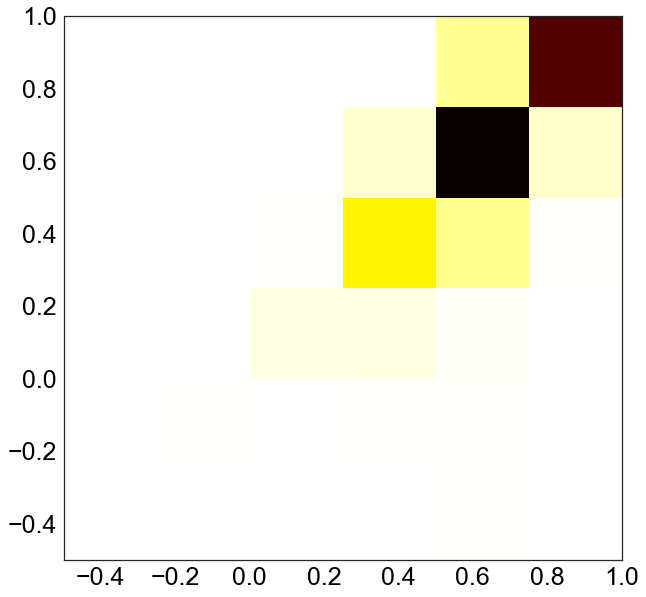

In [16]:
# plot_2d_hist(genie_CC1p['truth_Pmu'],genie_CC1p['smeared_Pmu'],bins=Bins['Pmu']);
# plot_2d_hist(selected_CC1p['truth_Pp'],selected_CC1p['smeared_Pp'],bins=Bins['Pp']);
# plot_2d_hist(180/np.pi*selected_CC1p['truth_Pp_theta'],180/np.pi*selected_CC1p['smeared_Pp_theta'],bins=Bins['theta(p)']);
# plt.hist(selected_CC1p['smeared_Pp_theta']);
plot_2d_hist(selected_CC1p['truth_Pp_cos_theta'],selected_CC1p['smeared_Pp_cos_theta'],bins=Bins['cos(theta(p))']);

## export to csv

In [17]:
outcsvname = prefix+'selected_CC 1p.csv'
selected_CC1p.to_csv(outcsvname)
print 'saved selected CC1p to',outcsvname

outcsvname = prefix+'genie_CC 1p.csv'
genie_CC1p.to_csv(outcsvname)
print 'saved genie CC1p to',outcsvname

saved selected CC1p to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_CC 1p.csv
saved genie CC1p to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_genie_CC 1p.csv


## get the efficiency with the smeared observables

In [10]:
def compute_effiency(bins=Bins['Pmu']
                     ,xvar='smeared_Pmu'
                     ,xlabel=(Vlabels['Pmu']+Units['Pmu'])
                     ,ylabel=r'$\bar{\epsilon}$'
                     ,do_draw=True
                     ,mul=1
                    ):
    mid = 0.5*(bins[1:]+bins[:-1]); bin_width=0.5*(mid[1]-mid[0])
    h = dict()
    h['generated'],_ = np.histogram(mul*genie_CC1p[xvar],bins=bins)
    h['selected'],_ = np.histogram(mul*selected_CC1p[xvar],bins=bins)

    h['eff'],h['eff err'] = [],[]
    for i in range(len(bins)-1):
        eff,eff_err = get_eff(Ngen=h['generated'][i],Nsel=h['selected'][i])
        h['eff'].append(eff)
        h['eff err'].append(eff_err)
    print 'done computing efficiency.'
    
    if do_draw:
        fig=plt.figure(figsize=(20,6))
        ax=fig.add_subplot(1,2,1)
        for label,color in zip(['generated','selected'],['forestgreen','royalblue']):
            plt.errorbar(x=mid,xerr=bin_width,y=h[label],yerr=np.sqrt(h[label])
                         ,color=color,capsize=10,fmt='.',markersize=0,label=label)
        set_axes(ax,xlabel,'counts',do_add_grid=True,do_add_legend=True)

        ax=fig.add_subplot(1,2,2)
        plt.errorbar(x=mid,xerr=bin_width,y=h['eff'],yerr=h['eff err']
                         ,color='black',capsize=10,fmt='.',markersize=0)
        set_axes(ax,xlabel,ylabel,do_add_grid=True,ylim=(0,1.05*np.max(h['eff']+h['eff err'])))
    print 'done drawing.'
    
    # save to csv
    np.savetxt(Paths['efficiency maps'] + "eff_%s_%d_bins.csv"%(xvar,len(bins)-1), h['eff'], delimiter=",")
    np.savetxt(Paths['efficiency maps'] + "eff_err_%s_%d_bins.csv"%(xvar,len(bins)-1), h['eff err'], delimiter=",")
    print 'saved efficiency into',Paths['efficiency maps'] + "eff_%s_%d_bins.csv"%(xvar,len(bins)-1),'\n and uncertainty'

done computing efficiency.
done drawing.
saved efficiency into /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/efficeincy_maps/eff_smeared_Pmu_6_bins.csv 
 and uncertainty


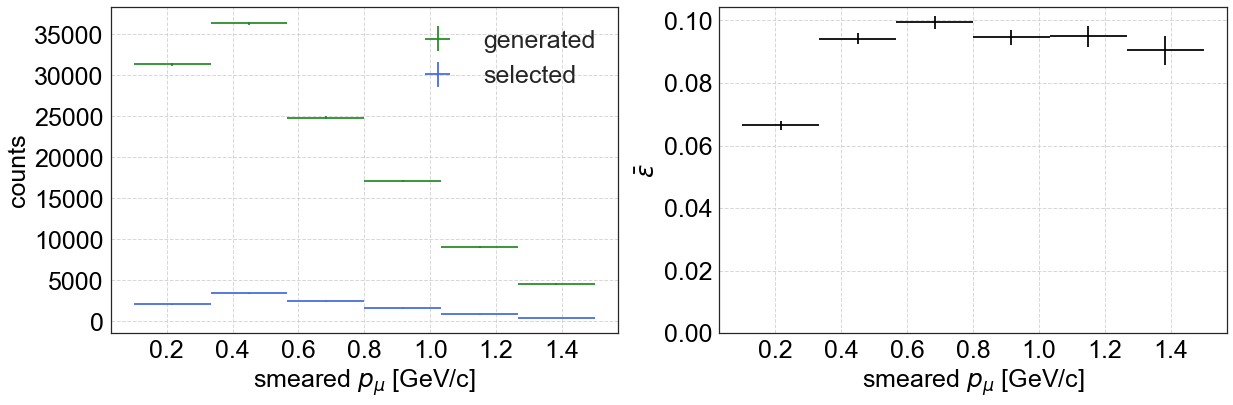

In [22]:
# compute_effiency(bins=Bins['Pmu']
#                      ,xvar='truth_Pmu'
#                      ,xlabel=r'truth '+Labels['Pmu']
#                      ,ylabel=r'$\epsilon$'
#                      ,do_draw=True)
compute_effiency(bins=Bins['Pmu']
                     ,xvar='smeared_Pmu'
                     ,xlabel=r'smeared '+(Vlabels['Pmu']+' ['+Units['Pmu']+']')
                     ,ylabel=r'$\bar{\epsilon}$'
                     ,do_draw=True)

done computing efficiency.
done drawing.
saved efficiency into /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/efficeincy_maps/eff_smeared_Pmu_cos_theta_6_bins.csv 
 and uncertainty


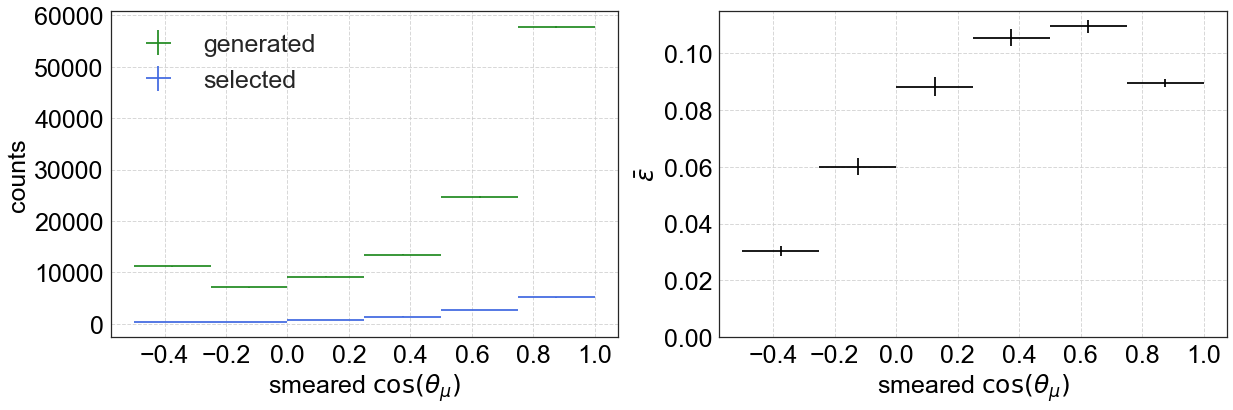

In [24]:
# compute_effiency(bins=Bins['theta(mu)']
#                      ,xvar='truth_Pmu_theta',mul=180./np.pi
#                      ,xlabel=r'truth '+Labels['theta(mu)']
#                      ,ylabel=r'$\epsilon$'
#                      ,do_draw=True)
# compute_effiency(bins=Bins['theta(mu)']
#                      ,xvar='smeared_Pmu_theta',mul=180./np.pi
#                      ,xlabel=r'smeared '+Labels['theta(mu)']
#                      ,ylabel=r'$\bar{\epsilon}$'
#                      ,do_draw=True)
compute_effiency(bins=Bins['cos(theta(mu))']
                     ,xvar='smeared_Pmu_cos_theta'
                     ,xlabel=r'smeared '+Vlabels['cos(theta(mu))']
                     ,ylabel=r'$\bar{\epsilon}$'
                     ,do_draw=True)

done computing efficiency.
done drawing.
saved efficiency into /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/efficeincy_maps/eff_smeared_Pp_6_bins.csv 
 and uncertainty


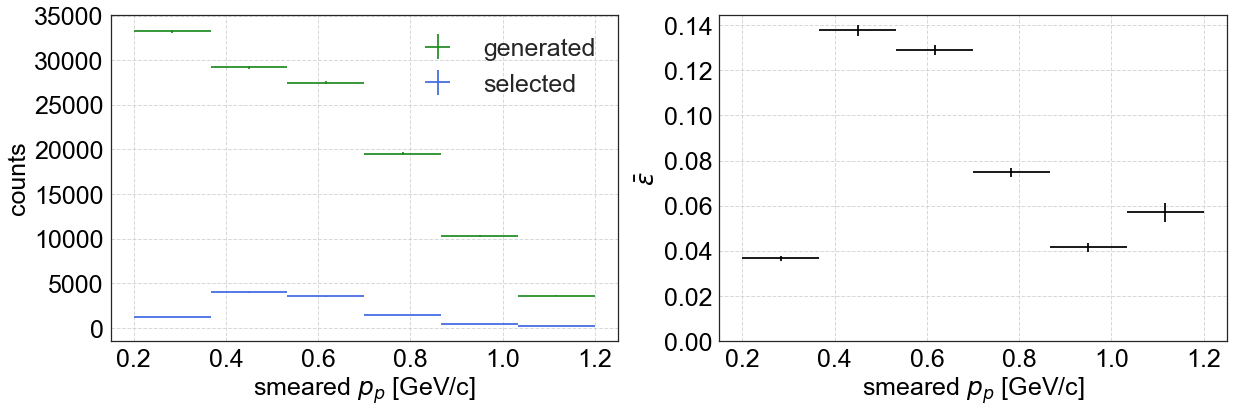

In [25]:
# compute_effiency(bins=Bins['Pp']
#                      ,xvar='truth_Pp'
#                      ,xlabel='truth '+Labels['Pp']
#                      ,ylabel=r'$\epsilon$'
#                      ,do_draw=True)
compute_effiency(bins=Bins['Pp']
                     ,xvar='smeared_Pp'
                     ,xlabel=r'smeared '+(Vlabels['Pp']+' ['+Units['Pp']+']')
                     ,ylabel=r'$\bar{\epsilon}$'
                     ,do_draw=True)

done computing efficiency.
done drawing.
saved efficiency into /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/efficeincy_maps/eff_smeared_Pp_cos_theta_6_bins.csv 
 and uncertainty


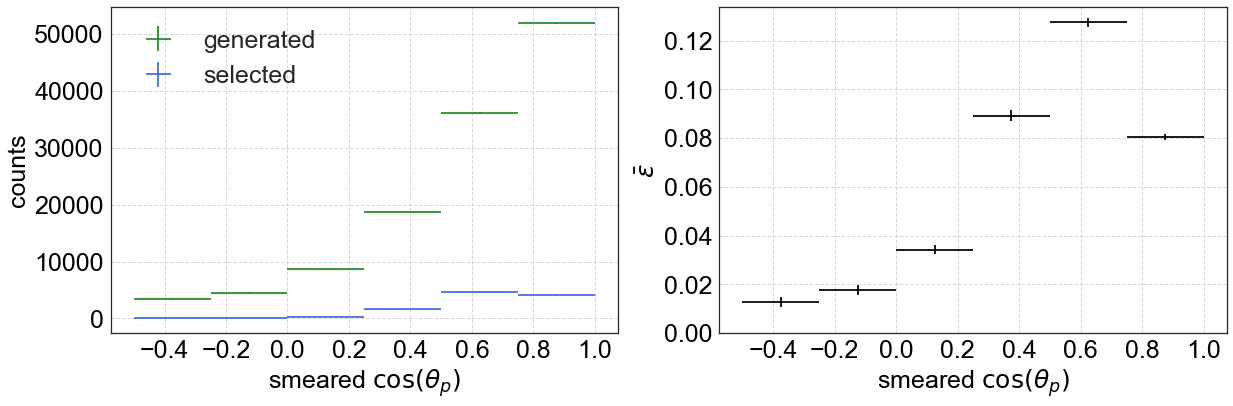

In [26]:
# compute_effiency(bins=Bins['theta(p)']
#                      ,xvar='truth_Pp_theta',mul=180./np.pi
#                      ,xlabel=r'truth '+Labels['theta(p)']
#                      ,ylabel=r'$\epsilon$'
#                      ,do_draw=True)
# compute_effiency(bins=Bins['theta(p)']
#                      ,xvar='smeared_Pp_theta',mul=180./np.pi
#                      ,xlabel=r'smeared '+Labels['theta(p)']
#                      ,ylabel=r'$\bar{\epsilon}$'
#                      ,do_draw=True)

compute_effiency(bins=Bins['cos(theta(p))']
                 ,xvar='smeared_Pp_cos_theta'
                 ,xlabel=r'smeared '+Vlabels['cos(theta(p))']
                 ,ylabel=r'$\bar{\epsilon}$'                 
                 ,do_draw=True)

# determine where to cut out events by the efficiency as a function of the truth-variables

done computing efficiency.
done drawing.
saved efficiency into /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/efficeincy_maps/eff_truth_Pmu_99_bins.csv 
 and uncertainty
done computing efficiency.
done drawing.
saved efficiency into /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/efficeincy_maps/eff_truth_Pp_99_bins.csv 
 and uncertainty
done computing efficiency.
done drawing.
saved efficiency into /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/efficeincy_maps/eff_truth_Pmu_cos_theta_99_bins.csv 
 and uncertainty
done computing efficiency.
done drawing.
saved efficiency into /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/efficeincy_maps/eff_truth_Pp_cos_theta_99_bins.csv 
 and uncertainty


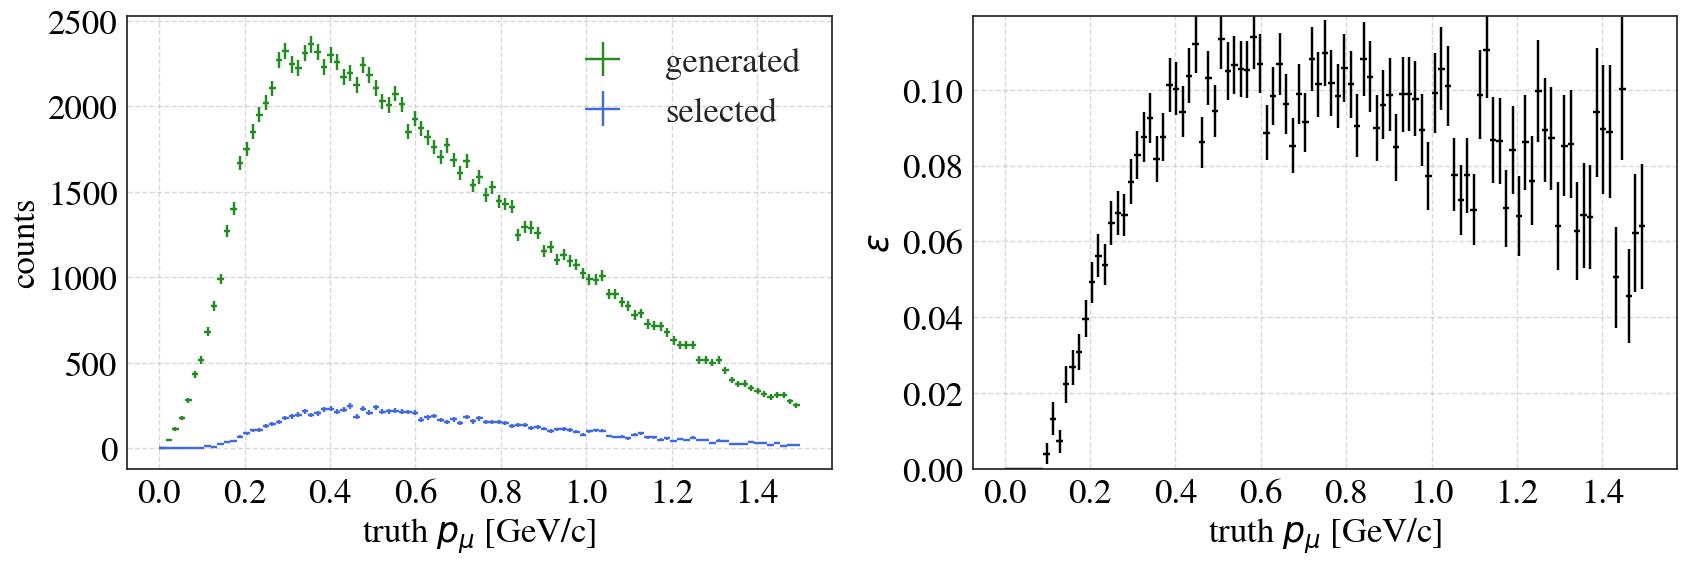

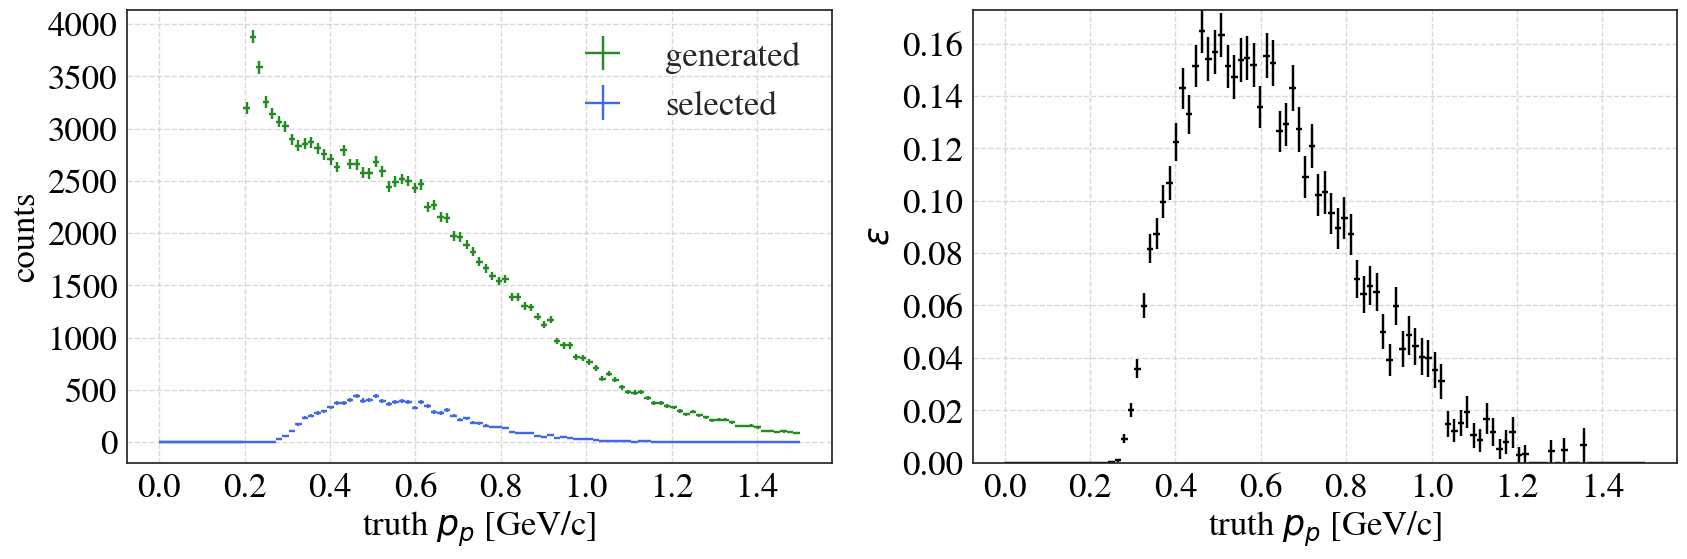

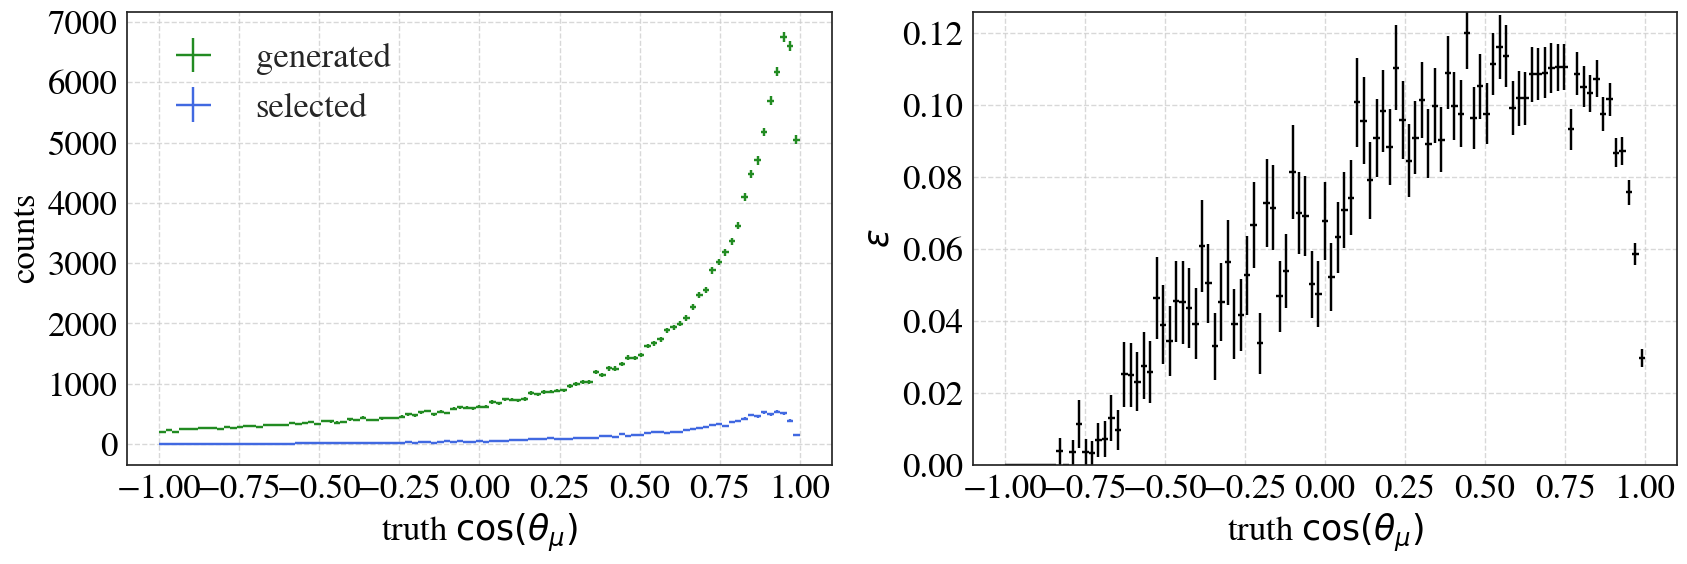

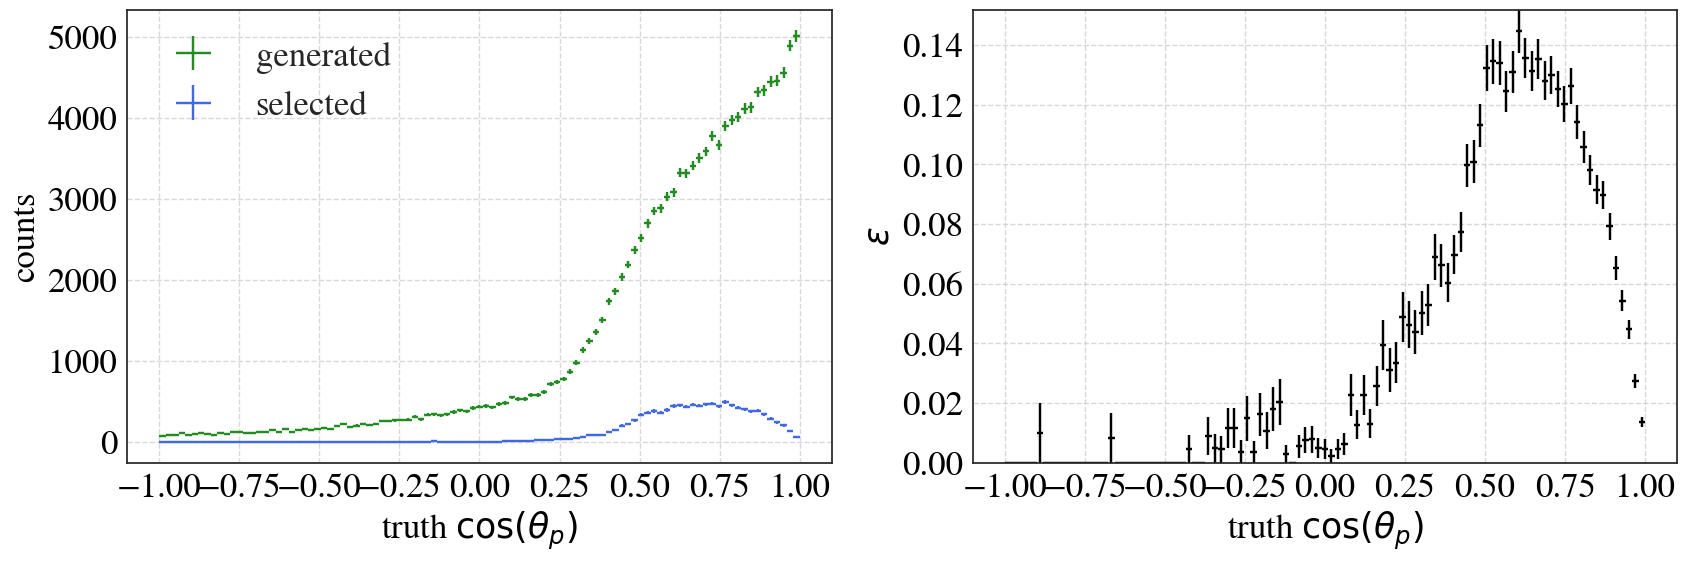

In [15]:
compute_effiency(bins=linspace(0,1.5,100)
                     ,xvar='truth_Pmu'
                     ,xlabel=r'truth '+(Vlabels['Pmu']+' ['+Units['Pmu']+']')
                     ,ylabel=r'$\epsilon$'
                     ,do_draw=True)
compute_effiency(bins=linspace(0,1.5,100)
                     ,xvar='truth_Pp'
                     ,xlabel=r'truth '+(Vlabels['Pp']+' ['+Units['Pp']+']')
                     ,ylabel=r'$\epsilon$'
                     ,do_draw=True)
compute_effiency(bins=linspace(-1,1,100)
                 ,xvar='truth_Pmu_cos_theta'
                 ,xlabel=r'truth '+Vlabels['cos(theta(mu))']
                     ,ylabel=r'$\epsilon$'
                     ,do_draw=True)
compute_effiency(bins=linspace(-1,1,100)
                 ,xvar='truth_Pp_cos_theta'
                 ,xlabel=r'truth '+Vlabels['cos(theta(p))']
                     ,ylabel=r'$\epsilon$'
                     ,do_draw=True)